<a href="https://colab.research.google.com/github/flohmannjr/TCC530/blob/main/TCC530_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC530 - Modelos

## Importações de bibliotecas

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Bidirectional, Concatenate, Conv1D, Dense
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Input, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
!pip install -U "tensorflow-text==2.13.*"
import tensorflow_text as tf_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 51.9 MB/s eta 0:00:00


## Configurações

In [3]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

sns.set_style("darkgrid")

### Constantes

In [4]:
SEMENTE = 2008193

LIMITE_DICIONARIO = 90000

MAXIMO_MODELOS = 10

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

ESPACO_SAIDA = 50
NUCLEO_TAMANHO = 64
PREENCHIMENTO = 'same'

ABANDONOS = 0.1

PERDA = 'binary_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

## Dados

In [5]:
dados = pd.read_csv('https://raw.githubusercontent.com/Edvandro-Nogueira/TCC-Univesp/main/dados_noticias.csv',
                    sep=';')

In [6]:
dados = dados[dados['noticias'].notna()]

In [7]:
dados['palavras'] = dados['noticias'].str.split().str.len()

In [8]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10738 entries, 0 to 10757
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   noticias  10738 non-null  object
 1   classe    10738 non-null  int64 
 2   palavras  10738 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 335.6+ KB


In [9]:
dados

,noticias,classe,palavras
0,katia abreu diz vai colocar expulsao moldura n...,0,99
1,ray peita bolsonaro conservador fake entrevist...,0,143
2,reinaldo azevedo desmascarado policia federal ...,0,153
3,relatorio assustador bndes mostra dinheiro pub...,0,339
4,radialista americano fala sobre pt vendem ilus...,0,66
...,...,...,...
10753,"Aug 26, 2020 — É falso que neurocientista brit...",0,50
10754,19/08/2020 - 17:45 / Atualizado em 19/08/2020 ...,0,59
10755,"Jun 6, 2020 — No Reino Unido, 80% da população...",0,56
10756,Estudo do pesquisador Karl Friston conclui que...,0,14


In [10]:
dados['classe'].value_counts()

0    6128
1    4610
Name: classe, dtype: int64

In [11]:
X = dados['noticias']
y = dados['classe']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=SEMENTE)

In [12]:
# X_train.shape, X_val.shape, y_train.shape, y_val.shape

In [13]:
# X_train.dtype, X_val.dtype, y_train.dtype, y_val.dtype

### Converter texto em números

In [14]:
# Quantidade máxima de palavras em 99% das notícias.
palavras_99 = int(np.percentile(dados['palavras'], 99))

print(f"Máximo.: {np.max(dados['palavras'])}")
print(f"Média..: {np.mean(dados['palavras'])}")
print(f"99%....: {palavras_99}")

Máximo.: 4229
Média..: 256.1611100763643
99%....: 1453


In [15]:
tamanho_texto = palavras_99

#### Vetorização (Vectorization)

In [16]:
vetorizador = TextVectorization(max_tokens=LIMITE_DICIONARIO,               # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',  # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                         # (Default) Separador de tokens.
                                ngrams=None,                                # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                          # (Default) Como mapear tokens para números.
                                output_sequence_length=tamanho_texto)       # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [17]:
# vetorizador.adapt(X_train)
vetorizador.adapt(X)

In [18]:
# texto = random.choice(X_train)
# print(texto)

# vet = vetorizador([texto])

In [19]:
# with np.printoptions(threshold=np.inf):
#     print(vet)

In [20]:
vocabulario = vetorizador.get_vocabulary()

In [21]:
# [UNK] = Desconhecido, fora do limite do dicionário.
len(vocabulario), vocabulario[:10], vocabulario[-10:]

(85750,
 ['',
  '[UNK]',
  'nao',
  'lula',
  'ser',
  'tambem',
  'sao',
  'presidente',
  'disse',
  'sobre'],
 ['02062017',
  '02032020',
  '01h16',
  '01310915',
  '01122017',
  '00h53min',
  '00h33',
  '0008',
  '00000000',
  '000'])

#### Incorporação (Embedding)

In [22]:
incorporador = Embedding(input_dim=LIMITE_DICIONARIO,  # Tamanho do vocabulário de entrada.
                         output_dim=128,               # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=tamanho_texto)   # Tamanho do texto de entrada.

In [23]:
# texto = random.choice(X_train)
# print(texto)

# incorporador(vetorizador([texto]))

## Funções

In [24]:
def build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelo_nome):
    text_input = Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = Dropout(0.1)(net)
    net = Dense(1, activation='sigmoid', name='classifier')(net)
    return Model(text_input, net, name=modelo_nome)

def grafico_historico_por_iteracao(historico):

    for chave in historico.history.keys():
        sns.lineplot(data=historico.history[chave], label=chave)

    plt.title('Histórico por iteração')
    plt.xlabel('Iteração')
    plt.ylabel('')

    plt.legend(frameon=True, facecolor='white')
    plt.show()

def avaliar_modelo(validacao, previsao, rotulos=None, cmap='summer_r'):
    print(classification_report(validacao, previsao, target_names=rotulos))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, display_labels=rotulos, xticks_rotation='vertical', cmap=cmap)
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, target_names=rotulos, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

def dados_modelo(indice):
    avaliacoes[indice] = modelos[indice].evaluate(X_val, y_val)
    probabilidades[indice] = modelos[indice].predict(X_val)
    previsoes[indice] = tf.squeeze(tf.round(probabilidades[indice]))
    relatorios[indice] = avaliar_modelo(y_val, previsoes[indice])

## Modelos

In [25]:
modelos = [None] * MAXIMO_MODELOS

avaliacoes     = [None] * MAXIMO_MODELOS
probabilidades = [None] * MAXIMO_MODELOS
previsoes      = [None] * MAXIMO_MODELOS
relatorios     = [None] * MAXIMO_MODELOS

historicos = [None] * MAXIMO_MODELOS

modelo_numero = 0

### Modelo 0: Naive Bayes com codificador TF-IDF (baseline)

In [26]:
modelo_nome = f'modelo_{modelo_numero}_naive_bayes'

modelos[modelo_numero] = Pipeline([('tdidf', TfidfVectorizer()),
                                   ('clf', MultinomialNB())]) # clf = classifier

modelos[modelo_numero].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
previsoes[modelo_numero] = modelos[modelo_numero].predict(X_val)

              precision    recall  f1-score   support

           0       0.79      0.59      0.67      1146
           1       0.56      0.76      0.65       787

    accuracy                           0.66      1933
   macro avg       0.67      0.68      0.66      1933
weighted avg       0.69      0.66      0.66      1933



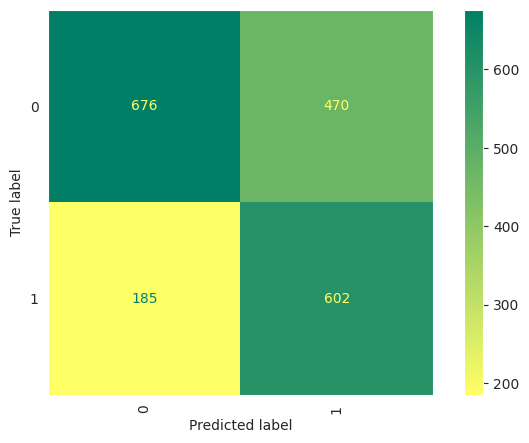

In [28]:
relatorios[modelo_numero] = avaliar_modelo(y_val, previsoes[modelo_numero])

In [29]:
relatorios[modelo_numero]

{'acuracia': 0.661148473874806,
 'precisao': 0.6941109283036968,
 'revocacao': 0.661148473874806,
 'pontuacao-f1': 0.6630638729061095}

### Camadas iniciais padronizadas

In [30]:
%%time

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas_iniciais = vetorizador(entradas)
camadas_iniciais = incorporador(camadas_iniciais)

CPU times: user 64.5 ms, sys: 2.05 ms, total: 66.6 ms
Wall time: 113 ms


### Modelo 1: MLP

In [31]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_denso'

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/5
121/121 [==============================] - 44s 306ms/step - loss: 0.6378 - accuracy: 0.7570 - val_loss: 0.5675 - val_accuracy: 0.8624
Epoch 2/5
121/121 [==============================] - 26s 214ms/step - loss: 0.4767 - accuracy: 0.8741 - val_loss: 0.4238 - val_accuracy: 0.8629
Epoch 3/5
121/121 [==============================] - 26s 216ms/step - loss: 0.3376 - accuracy: 0.8842 - val_loss: 0.3428 - val_accuracy: 0.8696
Epoch 4/5
121/121 [==============================] - 23s 193ms/step - loss: 0.2470 - accuracy: 0.9074 - val_loss: 0.2939 - val_accuracy: 0.8841
Epoch 5/5
121/121 [==============================] - 24s 193ms/step - loss: 0.1811 - accuracy: 0.9449 - val_loss: 0.2640 - val_accuracy: 0.8939
CPU times: user 1min 37s, sys: 2.28 s, total: 1min 39s
Wall time: 3min 23s


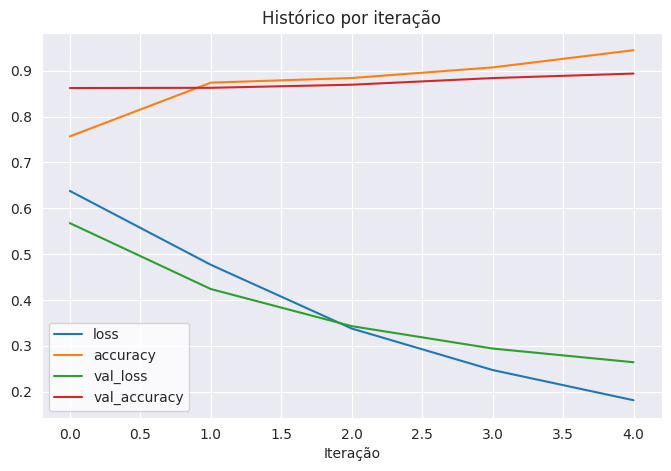

In [32]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1146
           1       0.93      0.80      0.86       787

    accuracy                           0.89      1933
   macro avg       0.90      0.88      0.89      1933
weighted avg       0.90      0.89      0.89      1933



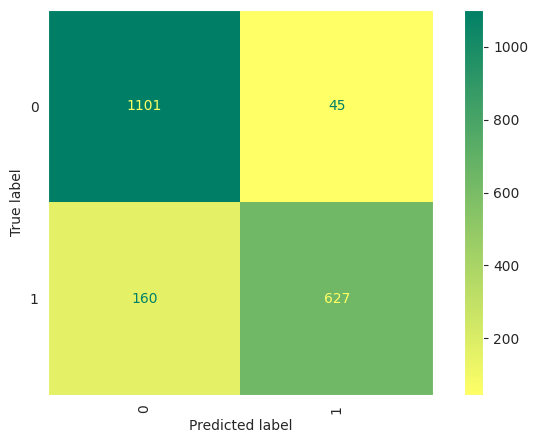

In [33]:
dados_modelo(modelo_numero)

In [34]:
relatorios[modelo_numero]

{'acuracia': 0.8939472322814278,
 'precisao': 0.8975120026466086,
 'revocacao': 0.8939472322814278,
 'pontuacao-f1': 0.8923010921343473}

### Modelo 2: SVM

In [35]:
# %%time

# modelo_numero += 1

# modelo_nome = f'modelo_{modelo_numero}_svm'

# modelos[modelo_numero] = SVC()

# modelos[modelo_numero].fit(X_train, y_train)
# modelos[modelo_numero].fit(incorporador(vetorizador(X_train)).numpy(), y_train)

In [36]:
# grafico_historico_por_iteracao(historicos[modelo_numero])

In [37]:
# dados_modelo(modelo_numero)

In [38]:
# relatorios[modelo_numero]

### Modelo 3: DT

In [39]:
# %%time

# modelo_numero += 1

# modelo_nome = f'modelo_{modelo_numero}_dt'

# modelos[modelo_numero] = DecisionTreeClassifier()

# modelos[modelo_numero].fit(X_train, y_train)
# modelos[modelo_numero].fit(incorporador(vetorizador(X_train)).numpy(), y_train)

In [40]:
# grafico_historico_por_iteracao(historicos[modelo_numero])

In [41]:
# dados_modelo(modelo_numero)

In [42]:
# relatorios[modelo_numero]

### Modelo 4: CNN

In [43]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_cnn'

camadas = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=NUCLEO_TAMANHO,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas_iniciais)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/5
121/121 [==============================] - 37s 252ms/step - loss: 0.4719 - accuracy: 0.7795 - val_loss: 0.3024 - val_accuracy: 0.8707
Epoch 2/5
121/121 [==============================] - 28s 228ms/step - loss: 0.1506 - accuracy: 0.9336 - val_loss: 0.2646 - val_accuracy: 0.8857
Epoch 3/5
121/121 [==============================] - 25s 209ms/step - loss: 0.0410 - accuracy: 0.9885 - val_loss: 0.2843 - val_accuracy: 0.8898
Epoch 4/5
121/121 [==============================] - 25s 203ms/step - loss: 0.0141 - accuracy: 0.9965 - val_loss: 0.3144 - val_accuracy: 0.8872
Epoch 5/5
121/121 [==============================] - 24s 200ms/step - loss: 0.0098 - accuracy: 0.9966 - val_loss: 0.3341 - val_accuracy: 0.8877
CPU times: user 1min 45s, sys: 2.37 s, total: 1min 47s
Wall time: 2min 18s


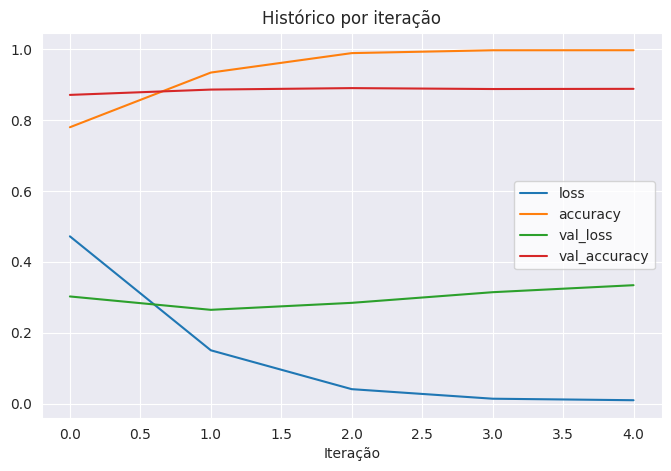

In [44]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1146
           1       0.87      0.86      0.86       787

    accuracy                           0.89      1933
   macro avg       0.88      0.88      0.88      1933
weighted avg       0.89      0.89      0.89      1933



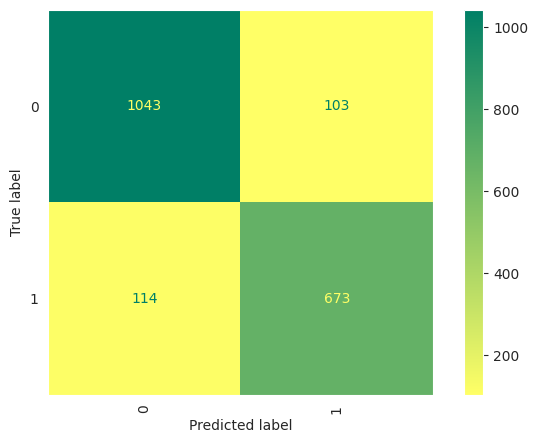

In [45]:
dados_modelo(modelo_numero)

In [46]:
relatorios[modelo_numero]

{'acuracia': 0.8877392653905846,
 'precisao': 0.8875446383675178,
 'revocacao': 0.8877392653905846,
 'pontuacao-f1': 0.8876123339020563}

### Modelo 5: DCNN

In [47]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_dcnn'

# Bigram

bigram = Conv1D(filters=ESPACO_SAIDA,
                kernel_size=2,
                activation=ATIVACAO_CNN,
                padding=PREENCHIMENTO,
                name='camada_bigram')(camadas_iniciais)

bigram = GlobalMaxPool1D(name='agrupamento_maximo_bigram')(bigram)

# Trigram

trigram = Conv1D(filters=ESPACO_SAIDA,
                 kernel_size=3,
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_trigram')(camadas_iniciais)

trigram = GlobalMaxPool1D(name='agrupamento_maximo_trigram')(trigram)

# Fourgram

fourgram = Conv1D(filters=ESPACO_SAIDA,
                  kernel_size=4,
                  activation=ATIVACAO_CNN,
                  padding=PREENCHIMENTO,
                  name='camada_fourgram')(camadas_iniciais)

fourgram = GlobalMaxPool1D(name='agrupamento_maximo_fourgram')(fourgram)

# Concatenação dos ngrams

# camadas = tf.concat([bigram, trigram, fourgram], axis=-1)
camadas = Concatenate(name="camada_concatenacao")([bigram, trigram, fourgram])

# Camada densa

camadas = Dense(units=512, activation=ATIVACAO_CNN, name='camada_densa')(camadas)

# Camada de abandono

camadas = Dropout(rate=ABANDONOS, name='camada_abandono')(camadas)

# Camada de saída

saidas = Dense(units=1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/5
121/121 [==============================] - 31s 232ms/step - loss: 0.2105 - accuracy: 0.9242 - val_loss: 0.2801 - val_accuracy: 0.8960
Epoch 2/5
121/121 [==============================] - 27s 223ms/step - loss: 0.0241 - accuracy: 0.9909 - val_loss: 0.2945 - val_accuracy: 0.9027
Epoch 3/5
121/121 [==============================] - 25s 207ms/step - loss: 0.0067 - accuracy: 0.9973 - val_loss: 0.3301 - val_accuracy: 0.8976
Epoch 4/5
121/121 [==============================] - 24s 197ms/step - loss: 0.0069 - accuracy: 0.9970 - val_loss: 0.3627 - val_accuracy: 0.9017
Epoch 5/5
121/121 [==============================] - 23s 192ms/step - loss: 0.0055 - accuracy: 0.9974 - val_loss: 0.3338 - val_accuracy: 0.9027
CPU times: user 1min 42s, sys: 1.96 s, total: 1min 44s
Wall time: 2min 23s


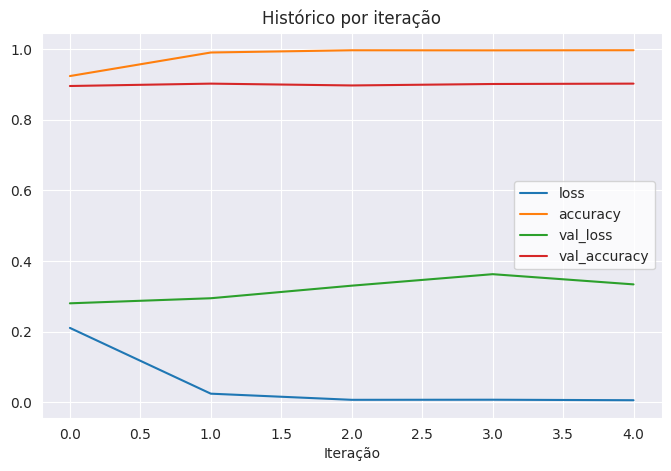

In [48]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      1146
           1       0.87      0.89      0.88       787

    accuracy                           0.90      1933
   macro avg       0.90      0.90      0.90      1933
weighted avg       0.90      0.90      0.90      1933



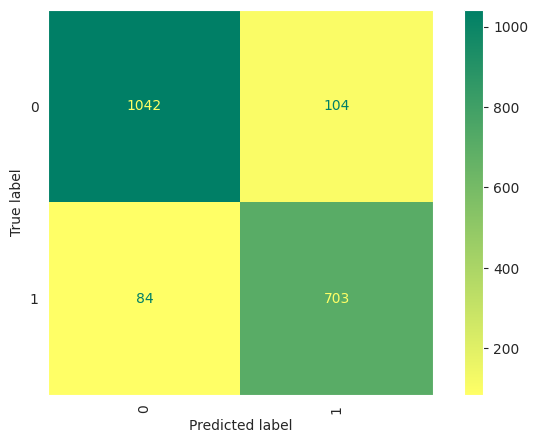

In [49]:
dados_modelo(modelo_numero)

In [50]:
relatorios[modelo_numero]

{'acuracia': 0.9027418520434558,
 'precisao': 0.9033033834614672,
 'revocacao': 0.9027418520434558,
 'pontuacao-f1': 0.9029239307019664}

### Modelo 6: RNN (LSTM Bidirecional)

In [51]:
%%time

modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_rnn'

# camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN, return_sequences=True))(camadas_iniciais)
# camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas)
camadas = Bidirectional(layer=LSTM(units=ESPACO_SAIDA, activation=ATIVACAO_RNN))(camadas_iniciais)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[modelo_numero] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/5
121/121 [==============================] - 40s 291ms/step - loss: 0.2952 - accuracy: 0.8783 - val_loss: 0.4633 - val_accuracy: 0.8251
Epoch 2/5
121/121 [==============================] - 33s 278ms/step - loss: 0.0924 - accuracy: 0.9797 - val_loss: 0.3645 - val_accuracy: 0.8831
Epoch 3/5
121/121 [==============================] - 31s 256ms/step - loss: 0.0604 - accuracy: 0.9843 - val_loss: 0.4480 - val_accuracy: 0.8717
Epoch 4/5
121/121 [==============================] - 32s 265ms/step - loss: 0.0414 - accuracy: 0.9898 - val_loss: 0.4763 - val_accuracy: 0.8712
Epoch 5/5
121/121 [==============================] - 30s 252ms/step - loss: 0.0732 - accuracy: 0.9821 - val_loss: 0.4953 - val_accuracy: 0.8707
CPU times: user 2min 28s, sys: 3.04 s, total: 2min 31s
Wall time: 3min 25s


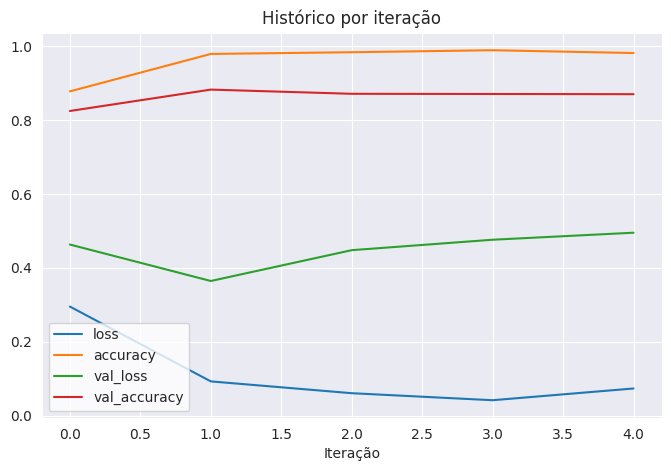

In [52]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 3s 34ms/step
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1146
           1       0.83      0.86      0.84       787

    accuracy                           0.87      1933
   macro avg       0.87      0.87      0.87      1933
weighted avg       0.87      0.87      0.87      1933



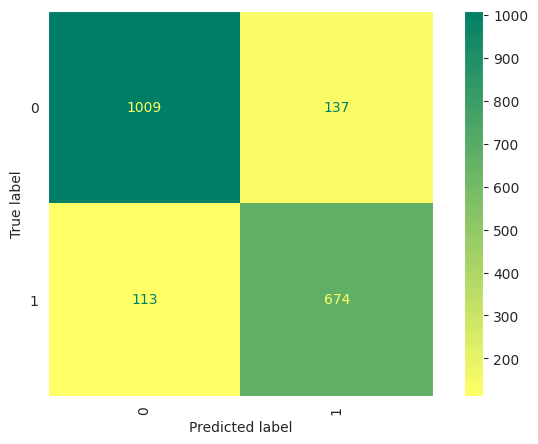

In [53]:
dados_modelo(modelo_numero)

In [54]:
relatorios[modelo_numero]

{'acuracia': 0.8706673564407656,
 'precisao': 0.8715142999006379,
 'revocacao': 0.8706673564407656,
 'pontuacao-f1': 0.8709542655771355}

### Modelo 7: Transformer

In [55]:
%%time

# modelo_numero += 1

modelo_nome = f'modelo_{modelo_numero}_transformer'

tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
tfhub_handle_encoder    = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2'

modelos[modelo_numero] = build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess, modelo_nome)

modelos[modelo_numero].compile(loss=PERDA,
                               optimizer=Adam(learning_rate=APRENDIZADO),
                               metrics=METRICAS)

historicos[modelo_numero] = modelos[modelo_numero].fit(x=X_train,
                                                       y=y_train,
                                                       batch_size=NUCLEO_TAMANHO,
                                                       epochs=ITERACOES,
                                                       validation_data=(X_val, y_val),
                                                       verbose=1)

Epoch 1/5
121/121 [==============================] - 85s 577ms/step - loss: 0.5932 - accuracy: 0.6914 - val_loss: 0.4945 - val_accuracy: 0.7667
Epoch 2/5
121/121 [==============================] - 61s 505ms/step - loss: 0.5286 - accuracy: 0.7505 - val_loss: 0.5370 - val_accuracy: 0.7372
Epoch 3/5
121/121 [==============================] - 56s 465ms/step - loss: 0.5096 - accuracy: 0.7659 - val_loss: 0.6166 - val_accuracy: 0.7300
Epoch 4/5
121/121 [==============================] - 58s 476ms/step - loss: 0.6163 - accuracy: 0.6757 - val_loss: 0.5765 - val_accuracy: 0.7310
Epoch 5/5
121/121 [==============================] - 54s 449ms/step - loss: 0.5408 - accuracy: 0.7352 - val_loss: 0.6599 - val_accuracy: 0.6674
CPU times: user 5min 38s, sys: 32 s, total: 6min 10s
Wall time: 5min 43s


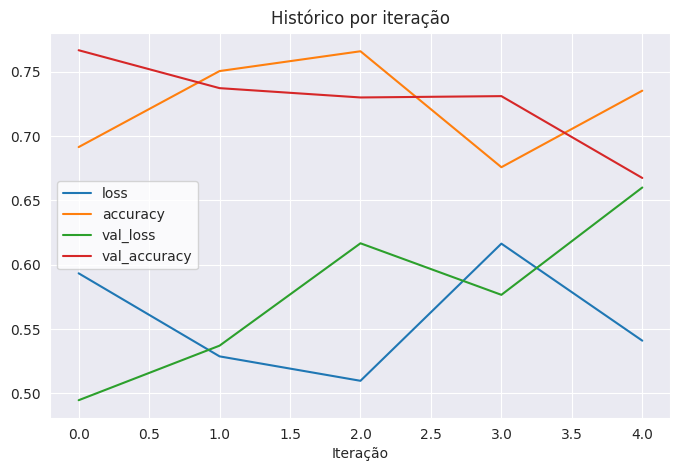

In [56]:
grafico_historico_por_iteracao(historicos[modelo_numero])

61/61 [==============================] - 7s 107ms/step
              precision    recall  f1-score   support

           0       0.81      0.58      0.67      1146
           1       0.56      0.80      0.66       787

    accuracy                           0.67      1933
   macro avg       0.69      0.69      0.67      1933
weighted avg       0.71      0.67      0.67      1933



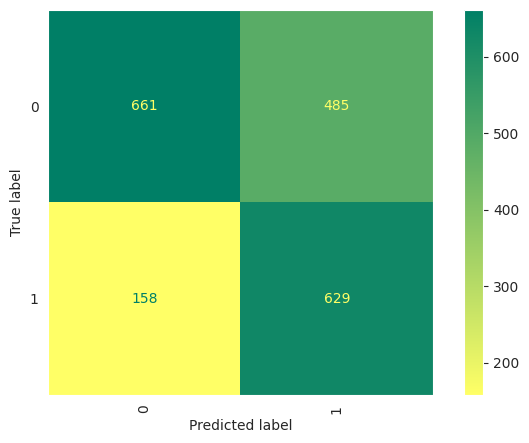

In [57]:
dados_modelo(modelo_numero)

In [58]:
relatorios[modelo_numero]

{'acuracia': 0.6673564407656493,
 'precisao': 0.7083709782749702,
 'revocacao': 0.6673564407656493,
 'pontuacao-f1': 0.6682882610889097}

## Comparar modelos

In [61]:
comparacao = pd.DataFrame([r for r in relatorios if r is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

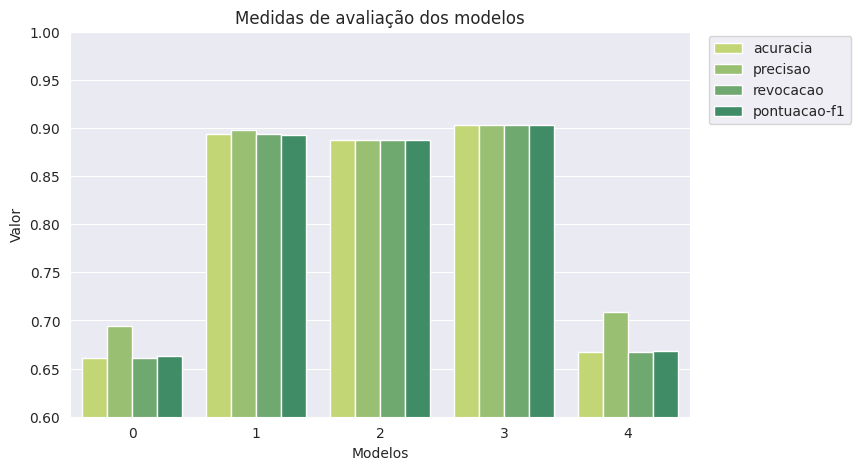

In [62]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.6, 1.0)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelos')
plt.ylabel('Valor')

plt.legend(loc=(1.03, 0.76));